In [1]:
%load_ext autoreload
%autoreload 2

# Examining circuit traces and energies 

The 2-3 mutations circuits somehow have the largest difference to their reference circuits compared to any other lower / higher mutations. There may be something strange about the circuits themselves causing this or perhaps there is mislabelling - we will try to rule that out here.

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.evolution.mutation import get_mutation_type_mapping
from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from explanations.data_enhancing import enhance_data, proc_info, melt, summ


root_dir = '..'

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'
fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'
fn_random_start = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'
fn_new = '../data/summarise_simulation/2023_06_28_012658/tabulated_mutation_info.csv'

In [26]:
data = pd.read_csv(fn_random_start)


Quickly fix data if needed (this has been fixed in data-generating scripts already)

In [27]:
# resorted = data[data['mutation_name'] != 'ref_circuit'][['circuit_name', 'mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions']]

# resorted = resorted.sort_values(['circuit_name', 'mutation_name'])
# resorted.index = sorted(resorted.index)
# resorted

# for circuit_name in resorted['circuit_name'].unique():
#     data.loc[(data['circuit_name'] == circuit_name) & (data['mutation_name'] != 'ref_circuit'), 
#              ['mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions']] = resorted[resorted['circuit_name'] == circuit_name][['mutation_name', 'mutation_num', 'mutation_type', 'mutation_positions']]
# data.to_csv('temp_tabulated_mutation_info.csv')


In [ ]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)


In [ ]:
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)

/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:128: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols2(info, k)].apply(
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:128: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>

In [ ]:
data['mutation_species'] = data['mutation_name'].str[:5]

## Choose which traces to compare

According to how much they stand out in energies / analytics (covered in other mutation* notebooks). This is all with *unbiased starting circuits*.

First looking at energy differences

In [74]:
e_diffs = dfm.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[dfm['mutation_num'] == 0].index[0]])
e_diffs['mutation_num'] = dfm['mutation_num']
e_diffs['energies_og'] = dfm['energies']


/tmp/ipykernel_89304/248495428.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_diffs = dfm.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[dfm['mutation_num'] == 0].index[0]])


Text(0.5, 0.98, 'Difference in individual interaction energies\nbetween mutated and reference circuits')

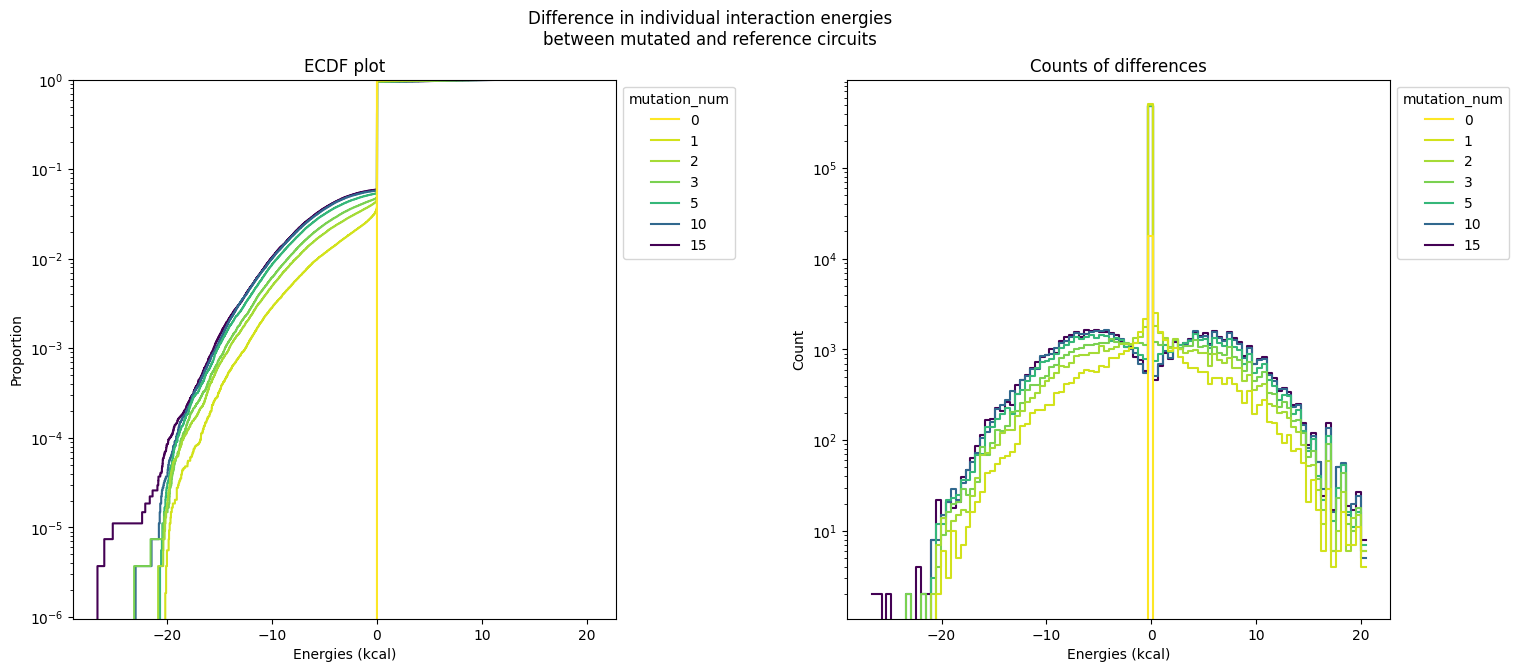

In [75]:

fig = plt.figure(figsize=(17, 7))
fig.subplots_adjust(hspace=0.325, wspace=0.425)
ax = plt.subplot(1,2,1)
sns.ecdfplot(e_diffs, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, True])
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('ECDF plot')

ax = plt.subplot(1,2,2)
sns.histplot(e_diffs, x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Counts of differences')

plt.suptitle('Difference in individual interaction energies\nbetween mutated and reference circuits')

In [7]:
e_diffs[e_diffs['mutation_num'] == 2]['energies'].abs().value_counts()

0.00     479937
4.49        224
3.26        208
8.14        175
6.30        167
          ...  
1.06          1
4.86          1
10.08         1
5.04          1
5.32          1
Name: energies, Length: 2858, dtype: int64

In [8]:
e_diffs[e_diffs['energies'] == 4.49]

,energies,mutation_num,energies_og
396322,4.49,15,-8.01
999294,4.49,15,-4.23
1034961,4.49,1,0.00
1034964,4.49,1,0.00
1034969,4.49,2,0.00
...,...,...,...
2783051,4.49,15,0.00
2783052,4.49,15,0.00
2783053,4.49,15,0.00
2783054,4.49,15,0.00


## Load circuit sequence

In [17]:
circuit_name = data['circuit_name'].unique()
path_to_template_circuit = list(data[data['mutation_num'] > 0]['path_to_template_circuit'].unique())
circuit_paths = jax.tree_util.tree_map(lambda x: os.path.join(root_dir, x), path_to_template_circuit)
fastas = jax.tree_util.tree_map(lambda cp: load_seq_from_FASTA(cp, as_type='dict'), circuit_paths)
fasta_d = dict(zip(circuit_name, fastas))
fasta_d

{'toy_circuit_combo0_100192': {'RNA_0': 'CGAGGAACAGUUGCACGAUA',
  'RNA_1': 'CGAAAAAGAAUUAGGGCGAA',
  'RNA_2': 'AGUCCCCACUCGUUUUGGCC'},
 'toy_circuit_combo0_100248': {'RNA_0': 'GAAGAUCUGCAGAAGUUAAA',
  'RNA_1': 'CACACGCCCGCAUGUCUAAC',
  'RNA_2': 'CUAGUCUGAUGAGUGAGAGA'},
 'toy_circuit_combo0_10028': {'RNA_0': 'CCAAUAGCUAUUGGCUAAUC',
  'RNA_1': 'ACUCACUAGGACGCCUGAUG',
  'RNA_2': 'GCCCCCGCGUUGUGCCUCCC'},
 'toy_circuit_combo0_101123': {'RNA_0': 'UGAUGGGAAAUGAACGUGUC',
  'RNA_1': 'CUGUAAAAACCUUUAGGGCC',
  'RNA_2': 'AGGCGAGUGGUGCAGCUCAC'},
 'toy_circuit_combo0_101196': {'RNA_0': 'CAUGAUGGAGUGCGCGGAAA',
  'RNA_1': 'GCUUCUUUGCUUGCACGCGA',
  'RNA_2': 'CUCCUAAUUCCGGCGUGGUU'},
 'toy_circuit_combo0_101549': {'RNA_0': 'UUACUUUAGCAUCCACAAUA',
  'RNA_1': 'CGAUCGCGAUGUUAUGGACC',
  'RNA_2': 'CCACCAACAGCUACAGGGCC'},
 'toy_circuit_combo0_102245': {'RNA_0': 'CAGCAAACUAUAUCGUUAGU',
  'RNA_1': 'AUGCCUAAAUAGGCCACAUU',
  'RNA_2': 'CCUCGCGGAGGACCGCAGGU'},
 'toy_circuit_combo0_102401': {'RNA_0': 'GCGAGUACACCAUCG

In [16]:

def reverse_mut_mapping(mut_encoding: int, sequence_type: str = 'RNA'):
    for k, v in get_mutation_type_mapping(sequence_type).items():
        if mut_encoding in list(v.values()):
            for mut, enc in v.items():
                if enc == mut_encoding:
                    return mut
    raise ValueError(
        f'Could not find mutation for mapping key {mut_encoding}.')
    
d = {v: v for v in jax.tree_util.tree_flatten(get_mutation_type_mapping('RNA'))[0]}
mutation_type_mapping_rev = jax.tree_util.tree_map(lambda x: reverse_mut_mapping(x), d)


def apply_values(sequence, indices, values):
    result = np.array(list(sequence))
    list(map(lambda idx, val: result.__setitem__(idx, val), indices, values))
    return ''.join(result)

Make sample sequences (mutated + normal)

In [18]:
data['mutation_type_explicit'] = jax.tree_util.tree_map(lambda mt: mutation_type_mapping_rev[mt], data['mutation_type'].to_list())

In [19]:
data['sample_seq'] = jax.tree_util.tree_map(lambda cn, sn, ms, mp, mt: fasta_d[cn][sn] if sn != ms else apply_values(fasta_d[cn][sn], mp, mt), 
                                            *[data[x].to_list() for x in ['circuit_name', 'sample_name', 'mutation_species', 'mutation_positions', 'mutation_type_explicit']])

In [20]:
RNA_nucs = ['A', 'C', 'G', 'U']

for l in RNA_nucs:
    data[l + '_counts'] = jax.tree_util.tree_map(lambda x: x.count(l), data['sample_seq'].to_list())

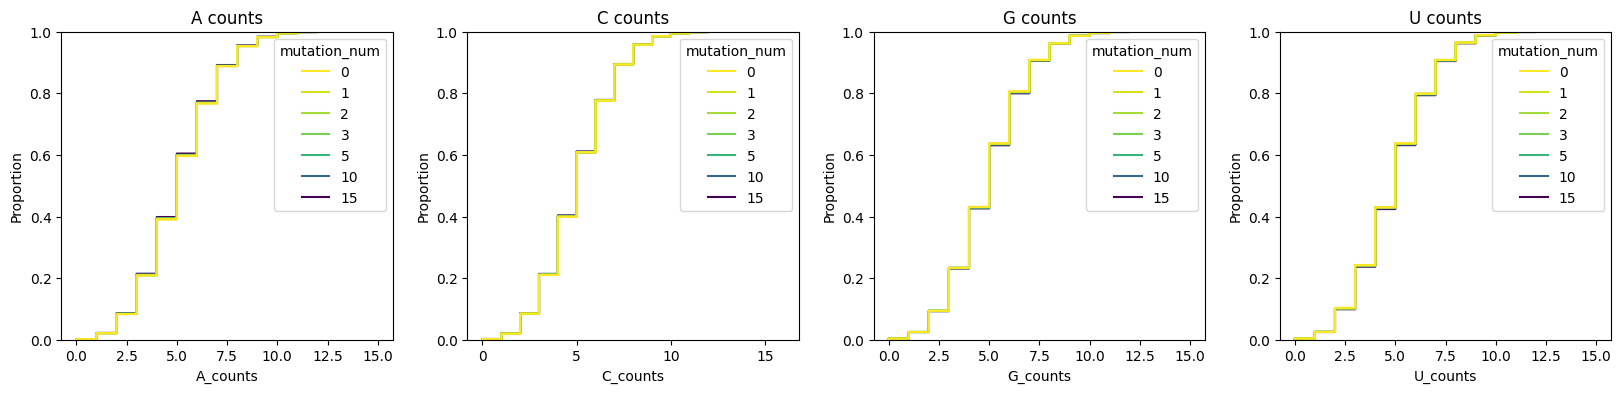

In [58]:
fig = plt.figure(figsize=(5 * len(RNA_nucs), 4))
fig.subplots_adjust(hspace=0.325, wspace=0.225)

for i, l in enumerate(RNA_nucs):
    ax = plt.subplot(1,len(RNA_nucs), i+1)
    sns.ecdfplot(data, x=l + '_counts', hue='mutation_num', palette='viridis_r')
    plt.title(l + ' counts')

Double check the energies simulated for these circuits


In [62]:
1201, 1231, 1233, 1234

In [102]:
data[data['mutation_name'] == 'RNA_0_m1-0'].index[0]

3

In [150]:
i = 120
circuit_chosen_idx = 3*i
circuit_chosen_idx = 1085995
circuit_chosen = data.iloc[circuit_chosen_idx]
# os.listdir(os.path.join(root_dir, circuit_chosen['path_to_template_circuit'].split('circuits/')[0], 'simulated_circuits', circuit_chosen['circuit_name']))
e_dir = os.path.join(fn_random_start.split('summarise')[0], 'mutation_effect_on_interactions_signal', circuit_chosen['circuit_name'], 'mutations', circuit_chosen['mutation_name'], 'energies')
energies = pd.read_csv(os.path.join(e_dir, os.listdir(e_dir)[0]))
print(circuit_chosen[['circuit_name', 'mutation_name']])
energies

circuit_name     toy_circuit_combo0_999765
mutation_name                   RNA_2_m5-8
Name: 1085995, dtype: object


,RNA_0,RNA_1,RNA_2_m5-8
0,-11.26,0.00,0.00
1,0.00,0.00,-6.79
2,0.00,-6.79,0.00


In [151]:

                # 'mutation_name': mutations['mutation_name'],
                # 'mutation_num': mutations['count'],
                # 'mutation_type': cast_astype(mutations['mutation_types'], int),
                # 'mutation_positions': cast_astype(mutations['positions'], int),
                # 'path_to_template_circuit': mutations['template_file']
print(e_dir)
circuit_chosen[get_true_interaction_cols(data, 'energies')]

../data/ensemble_mutation_effect_analysis/2023_06_05_164913/mutation_effect_on_interactions_signal/toy_circuit_combo0_999765/mutations/RNA_2_m5-8/energies


energies_0-0   -11.26
energies_0-1      0.0
energies_0-2      0.0
energies_1-0      0.0
energies_1-1      0.0
energies_1-2    -6.79
energies_2-0      0.0
energies_2-1    -6.79
energies_2-2      0.0
Name: 1085995, dtype: object

In [152]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict


Compare analytics

In [153]:
r_dir = os.path.join(fn_random_start.split('summarise')[0], 'mutation_effect_on_interactions_signal', circuit_chosen['circuit_name'], 'mutations', circuit_chosen['mutation_name'])
load_json_as_dict(os.path.join(r_dir, 'report_signal.json'))['RMSE_diff_to_base_circuit']

['0.0024012683',
 '0.0027146675',
 '0.0027146675',
 '0.008579154',
 '13.268302',
 '0.008579154',
 '0.0007227729',
 '13.243265',
 '13.243265']

In [162]:
r_dir2 = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/mutation_effect_on_interactions_signal/toy_circuit_combo0_100192/mutations/RNA_2_m10-5'
load_json_as_dict(os.path.join(r_dir2, 'report_signal.json'))['steady_states']

['0.2677884',
 '0.032107685',
 '0.032107685',
 '0.0038496964',
 '152.00607',
 '0.0038496964',
 '399.56625',
 '47.90779',
 '47.90779']

In [171]:
r_dir2 = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/mutation_effect_on_interactions_signal/toy_circuit_combo0_100192/mutations/RNA_0_m10-6'
load_json_as_dict(os.path.join(r_dir2, 'report_signal.json'))['steady_states']

['0.26765928',
 '0.12867911',
 '0.12867911',
 '0.06186341',
 '7.699701',
 '0.06186341',
 '399.46994',
 '192.04803',
 '192.04803']

## Why are the 2-3 mutations weakest, but m=5 is strong again?

Look at the distribution in actual nucleotides and make sure it's the same as the initial distribution